In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


print(torch.cuda.is_available())
#torch.manual_seed(2)

False


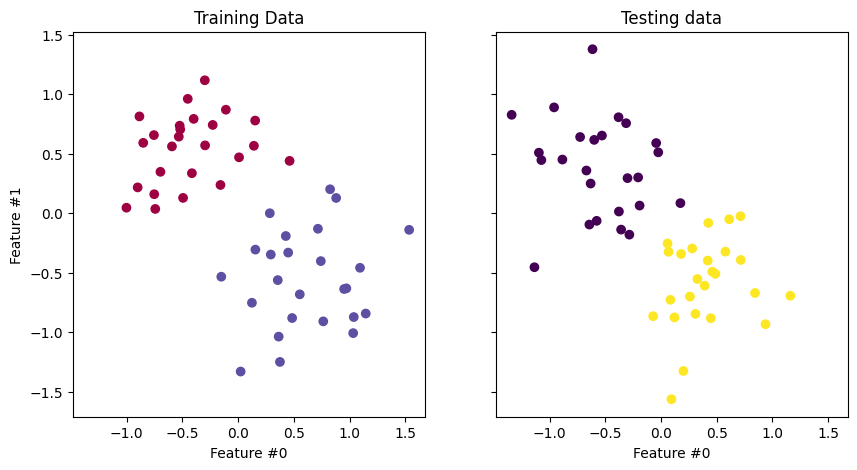

In [2]:
X, y = datasets.make_blobs(
    n_samples=100, centers=[[-0.5, 0.5], [0.5, -0.5]], cluster_std=0.4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50, random_state=26)

fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()


In [3]:

hidden = 8
class MultiLayer(torch.nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.linear = torch.nn.Linear(input, output)

        self.layer1 = torch.nn.Linear(input, hidden)
        torch.nn.init.kaiming_uniform_(self.layer1.weight, nonlinearity="relu")
        self.layer2 = torch.nn.Linear(hidden, hidden)
        torch.nn.init.kaiming_uniform_(self.layer2.weight, nonlinearity="relu")
        self.layer3 = torch.nn.Linear(hidden, output)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.sigmoid(self.layer3(x))
        return x

class BasicLinear(torch.nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.linear = torch.nn.Linear(input, output)

    def forward(self, x):
        n = self.linear(x)
        n = torch.sigmoid(n)
        return n

class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [4]:
batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 1
X shape: torch.Size([50, 2])
y shape: torch.Size([50])


In [5]:
model = MultiLayer(2, 1)
print(model)

learning_rate = 0.1
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10000
loss_values = []

for epoch in range(num_epochs):
     for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

MultiLayer(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)
Training Complete


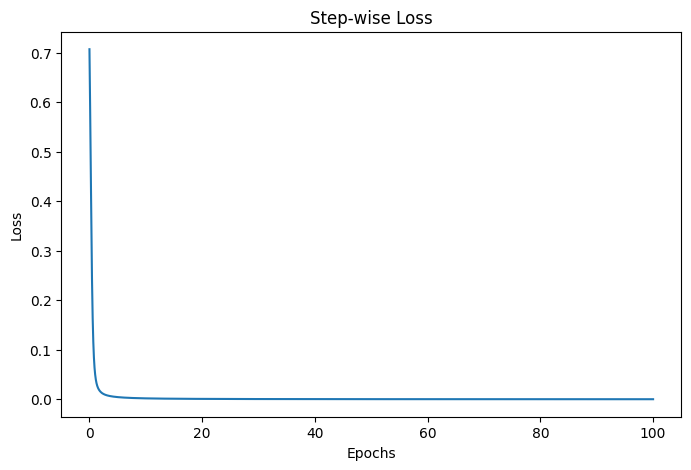

In [6]:
step = np.linspace(0, 100, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

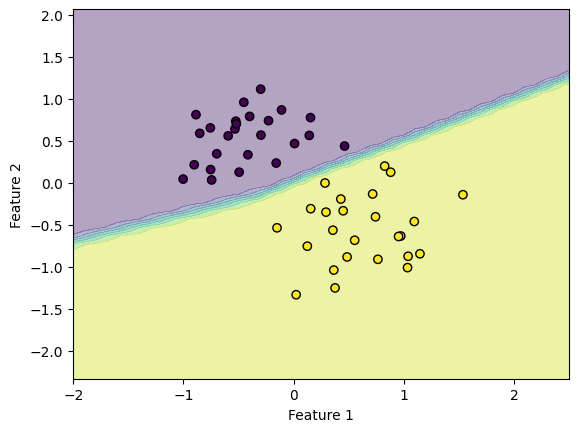

In [7]:
# Generate a grid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]

# Classify the points using the trained model
with torch.no_grad():
    outputs = model(torch.FloatTensor(grid))
    preds = (outputs).float().squeeze().numpy()

# Plot the points with different colors
plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()